# EECS 598 Backpropagation, optimization and regularization tutorial

Backpropagation tutorial is adapted from ( https://github.com/jcjohnson/pytorch-examples ).

## Introduction

Neural networks are powerful models that can approximate any function [(theorem)](https://en.wikipedia.org/wiki/Universal_approximation_theorem). By forward propagating an input through a neural network, we can extract information necessary to map that input to a desired output (e.g. class label). However, we need to adjust the network connections based on input/output pairs seen in training examples. This process can be achieved by the backpropagation algorithm (Backprop) and stochastic gradient descent (SGD).

This tutorial assumes understanding basic linear algebra operations such as dot product, and also assumes understanding of derivatives and the chain rule.

In this tutorial, we will cover:

* Forward propagation
* Backpropagation
* Optimization: SGD with Momentum, AdaGrad, RMSProp, Adam
* Regularization: L1, L2, Dropout, and Early Stopping.

We will use PyTorch throughout this tutorial.

In [1]:
from IPython.core.display import HTML, Image
from IPython.display import YouTubeVideo
from sympy import init_printing, Matrix, symbols, Rational
import sympy as sym
from warnings import filterwarnings
init_printing(use_latex = 'mathjax')
filterwarnings('ignore')


%matplotlib inline
import math
import matplotlib.pyplot as plt
import torch
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

## Forward propagation

Neural networks consist of many layers of computation that start from the lowest level (i.e. network input). Each layer consists of a dot product operation on the input followed by adding a bias term and an activation function.
Note: We do not add bias term in this tutorial, however, this is left for students as an exercise.

### Single layer computation

In [2]:
"""Create some dummy data points"""
# N is batch size; D_in is input dimension;
# H is hidden dimension
N, D_in, H = 64, 1000, 100
x = torch.randn(N, D_in, device=device)     # Input to network (layer0)

### Stacking multiple layers

In [3]:
"""Create weight for the single layer, and forward through it with a ReLU activation"""
w1 = torch.randn(D_in, H, device=device)  # First layer weight matrix
b1 = torch.zeros(1, H, device=device)        # First layer bias
a1 = x.mm(w1) + b1                        # Preactivation of layer 1
h1 = a1.clamp(min=0)                      # Layer 1 output (ReLU activated)

In [4]:
"""Create weight matrix for the next layer layer and forward through it taking the previous layer output as input"""
D_out = 10  
w2 = torch.randn(H, D_out, device=device)   # Second layer weight matrix
b2 = torch.zeros(1, D_out, device=device)   # Second layer bias
yhat = h1.mm(w2) + b2                       # Linear activation

## Backpropagation algorithm

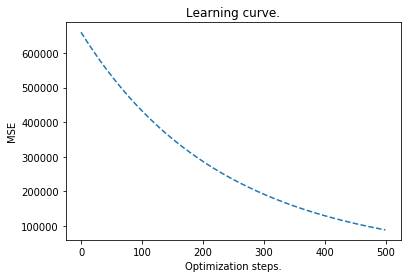

In [5]:
"""Forward propagate through a single layer network and backpropagate for max_steps steps"""

# Create random input/output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, D_out, device=device)
b1 = torch.zeros(1, D_out, device=device)

# Define optimization (learning) steps
max_steps = 500

# Define learning rate
learning_rate = 1e-6

# Container to store loss through training
loss_list = [] 
for t in range(max_steps):
    # Forward pass: compute predicted y (yhat)
    a1 = x.mm(w1) + b1                      # Layer 1 pre-activation
    yhat = a1.clone()                       # Layer 2 activation (linear activation)
    
    # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python number with loss.item().
    loss = (yhat - y).pow(2).sum()
    loss_list.append(loss)

    # Backprop to compute gradients of w1 with respect to the squared loss
    # Gradient of the loss layer with respect to the network output
    grad_yhat = 2.0 * (yhat - y)            # dC_dyhat
    
    # Gradients in layer 1 take in gradients of the cost with respect to its output
    # and computes its internal gradients. Note: activation is ReLU!!
    grad_a1 = grad_yhat.clone()             # dC_da1 -> dC_dyhat * dyhat_da1 Gradient of Linear activation
    grad_w1 = x.t().mm(grad_a1)             # dC_dw1 = da1_dw1 \dot dC_da1
    grad_b1 = torch.ones(1, N).mm(grad_a1)  # dC_db1 = da1_db1 \dot dC_da1
    grad_x = grad_a1.mm(w1.t())             # dC_dx = dC_da1 \dot da1_dx

    # No more layers! Let's update the parameters using gradient descent
    w1 -= learning_rate * grad_w1
    b1 -= learning_rate * grad_b1


# Plot learning curve
plt.title('Learning curve.')
plt.ylabel('MSE')
plt.xlabel('Optimization steps.')
plt.plot(loss_list, '--')

### Exercise: Implement a two layer forward and backward pass with ReLU activation in the first hidden layer (15 minutes)

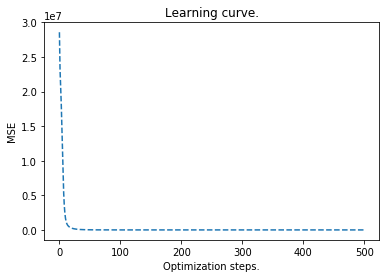

In [6]:
"""Forward propagate through network and backpropagate for max_steps steps"""

# Create random input/output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device)
b1 = torch.zeros(1, H, device=device)
w2 = torch.randn(H, D_out, device=device)
b2 = torch.zeros(1, D_out, device=device)

# Define optimization (learning) steps
max_steps = 500

# Define learning rate
learning_rate = 1e-6

# Container to store loss through training
loss_list = [] 
for t in range(max_steps):
    # Forward pass: compute predicted y (yhat)
    a1 = x.mm(w1) + b1              # Layer 1 preactivation 
    h1 = a1.clamp(min=0)            # Layer 1 output
    a2 = h1.mm(w2) + b2             # Layer 2 pre activation
    yhat = a2.clone()               # Layer 2 activation (linear activation)
    
    # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python number with loss.item().
    loss = (yhat - y).pow(2).sum()
    loss_list.append(loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    # Gradient of the loss layer with respect to input
    grad_yhat = 2.0 * (yhat - y)            # dC_dyhat
    
    
    # Gradients in layer 2 take in gradient of the cost with respect of its output
    # and computes its internal gradients. Note: activation is linear so
    grad_a2 = grad_yhat.clone()             # dC_da2 -> dC_yhat * dyhat_a2 Gradient of linear activation
    grad_w2 = h1.t().mm(grad_a2)            # dC_dw2 = da2_dw2 \dot dC_da2
    grad_b2 = torch.ones(1, N).mm(grad_a2)  # dC_db2 = dyhat_db2 \dot dC_da2
    grad_h1 = grad_a2.mm(w2.t())            # dC_dh1 = dC_da2 \dot da2_dh1

    
    # Gradients in layer 1 take in gradients of the cost with respect to its output
    # and computes its internal gradients. Note: activation is ReLU!!
    grad_a1 = grad_h1.clone()
    grad_a1[a1 < 0] = 0                     # dC_da1 -> dC_dh1 * dh1_da1 Gradient of ReLU activation
    grad_w1 = x.t().mm(grad_a1)             # dC_dw1 = da1_dw1 \dot dC_da1
    grad_b1 = torch.ones(1, N).mm(grad_a1)  # dC_db2 = da1_db1 \dot dC_da1
    grad_x = grad_a1.mm(w1.t())             # dC_dx = dC_da1 \dot da1_dx


    # No more layers! Let's update the parameters using gradient descent
    w1 -= learning_rate * grad_w1
    b1 -= learning_rate * grad_b1
    w2 -= learning_rate * grad_w2
    b2 -= learning_rate * grad_b2


# Plot learning curve
plt.title('Learning curve.')
plt.ylabel('MSE')
plt.xlabel('Optimization steps.')
plt.plot(loss_list, '--')

## Let's implement the model training in PyTorch!

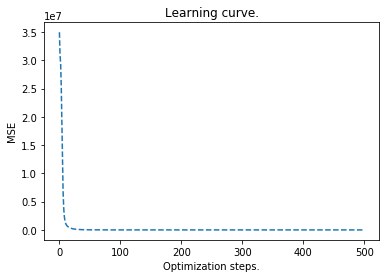

In [7]:
"""Forward propagate through network and backpropagate for max_steps steps with PyTorch modules"""
# Define optimization (learning) steps
max_steps = 500

# Define learning rate
learning_rate = 1e-6

# Container to store loss through training
loss_list = []

# Define network with similar initialization as the above example for consistency
# Layer1
layer1 = torch.nn.Linear(D_in, H)
layer1.weight = torch.nn.Parameter(torch.randn(H, D_in, device=device))
layer1.bias = torch.nn.Parameter(torch.zeros(H, device=device))

# Layer2
layer2 = torch.nn.Linear(H, D_out)
layer2.weight = torch.nn.Parameter(torch.randn(D_out, H, device=device))
layer2.bias = torch.nn.Parameter(torch.zeros(D_out, device=device))

net = torch.nn.Sequential(
    layer1,
    torch.nn.ReLU(),
    layer2
).to(device)

# Define optimizer
optimizer = torch.optim.SGD(net.parameters(), learning_rate)

# Define loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

for t in range(max_steps):
    # Forward pass and loss computation
    yhat = net.forward(x)
    loss = loss_fn(yhat, y)
    loss_list.append(loss.item())

    # Compute gradients using backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Take gradient step
    optimizer.step()


# Plot learning curve
plt.title('Learning curve.')
plt.ylabel('MSE')
plt.xlabel('Optimization steps.')
plt.plot(loss_list, '--')

## Optimization

There are a vast variety of optimizers that we can use to optimize our network parameters. We will focus on the following: SGD, SGD with Momentum, AdaGrad, Adadelta, RMSProp and Adam

#### SGD

Stochastic gradient descent (SGD) is simply a parameter update algorithm that maximizes an objective function:

$$
\begin{equation} 
\theta_{t+1} = \theta_t - \alpha \nabla_{\theta_t} J(\theta_t), \nonumber
\end{equation}
$$

where $\ell$ is the objective function we want to optimize, $\theta_t$ and $\theta_{t+1}$ are the parameters in the network before and after the update, respectively. Finally, $\alpha$ is the step size of the update (learning rate).


#### SGD with Momentum

SGD with momentum, in contrast to simple SGD, is a method that prevents oscillations during an update by adding the scaled previous update in the optimization to the current update:

$$
\begin{align}
v_{t+1} =& \gamma v_{t} + \alpha \nabla_{\theta_t} J(\theta_t), \nonumber \\
\theta_{t+1} =& \theta_t + v_{t+1}, \nonumber
\end{align}
$$

where $v_0$ is initialized to zeros in the first optimization of the timestep.


#### AdaGrad

Adagrad or adaptive gradient algorithm is a parameter update method that adapts the learning rate based on whether the parameters represent frequently ocurring features or infrecuently ocurring features.

$$
\begin{align}
g_{t} =& \nabla_{\theta_{t}} J(\theta_{t}), \nonumber \\
\theta_{t+1} =& \theta_{t} - \frac{\alpha}{\sqrt{G_{t} + \epsilon}} \odot g_{t}, \nonumber
\end{align}
$$

where $G_{t} \in \mathbb{R}^{d \times d}$ is a diagonal matrix where $G_{i,i}$ is $\sum^{t}_1 g_{t,i}^2$

#### RMSProp

RMSProp is similar to adagrad but with one difference: Instead of accumulating all past squared gradients, it looks at a window of previous gradients defined by a decaying factor.

$$
\begin{align}
\mathbb{E}[g^2]_{t} =& \gamma \mathbb{E}[g^2]_{t-1} + (1 - \gamma)g_{t}^2, \nonumber \\
\theta_{t+1} =& \theta_{t} - \frac{\alpha}{\sqrt{\mathbb{E}[g^2]_{t} + \epsilon}} \odot g_{t}, \nonumber
\end{align}
$$



#### Adadelta

Adadelta was developed around the same time as RMSProp. This update rule, however, completely remove the learning rate from the equation by a running average of the squared parameter updates in the numerator:

$$
\begin{align}
\mathbb{E}[g^2]_{t} =& \rho \mathbb{E}[g^2]_{t-1} + (1 - \rho)g_{t}^2, \nonumber \\
\mathbb{E}[\nabla \theta^2]_{t-1} =& \rho \mathbb{E}[\nabla \theta^2]_{t-2} + (1 - \rho)\nabla \theta_{t}^2, \nonumber \\
\nabla \theta_t =& -\frac{\sqrt{\mathbb{E}[\nabla \theta^2]_{t-1} + \epsilon}}{\sqrt{\mathbb{E}[g^2]_{t} + \epsilon}} \odot g_{t}, \nonumber \\
\theta_{t+1} =& \theta_{t} + \nabla \theta_t, \nonumber
\end{align}
$$

#### Adam

Adam or adaptive moment estimation is another adaptive learning rate method with respect to each parameter. This method also keeps an exponentially decaying average of past gradients. However, in constrast to previous methods, a momentum like term is used which keeps an exponentially decaying average of past gradients. The parameter update is performed as follows:

$$
\begin{align}
m_{t} =& \beta_1 m_{t-1} + (1 - \beta_1)g_{t}, \nonumber \\
v_{t} =& \beta_2 v_{t-1} + (1 - \beta_2)g_t^2, \nonumber \\
\hat{m}_t =& \frac{m_t}{1-\beta_1^t}, \nonumber \\
\hat{v}_t =& \frac{v_t}{1-\beta_2^t}, \nonumber \\
\theta_{t+1} =& \theta_{t} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon}\hat{m}_t, \nonumber
\end{align}
$$

where $m_t$ and $v_t$ are the first and second moment estimates of the gradients while $\hat{m}_t$ and $\hat{v}_t$ are bias corrected values of the two moments. 


Now that we have a rough intuition of what the previously mentioned optimizers are doing, we can run some network trainings and try each one of them! Take your time to play with the hyperparameters.

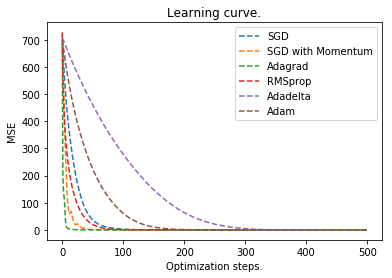

In [8]:
optimizers = []

# Remove optimizers by commenting lines below
# Try different hyperparameters to see any behavior change
optimizers.append(
    lambda params: torch.optim.SGD(
        params, lr=1e-4))
optimizers.append(
    lambda params: torch.optim.SGD(
        params, lr=1e-4, momentum=0.9))
optimizers.append(
    lambda params: torch.optim.Adagrad(
        params, lr=1e-2))
optimizers.append(
    lambda params: torch.optim.RMSprop(
        params, lr=1e-4, alpha=0.99, eps=1e-08))
optimizers.append(
    lambda params: torch.optim.Adadelta(
        params, rho=0.9, lr=1e-2, eps=1e-06))
optimizers.append(
    lambda params: torch.optim.Adam(
        params, lr=1e-4, eps=1e-08, betas=(0.9, 0.999)))

losses_list = []
optimizer_name = []
for optim in optimizers:
    """Forward propagate through network and backpropagate
    for max_steps steps with PyTorch modules"""
    # Define optimization (learning) steps
    max_steps = 500

    # Define learning rate
    learning_rate = 1e-6

    # Container to store loss through training
    closs_list = []

    # Build network
    net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).to(device)

    # Define optimizer
    optimizer = optim(net.parameters())

    # Define loss function
    loss_fn = torch.nn.MSELoss(reduction='sum')

    for t in range(max_steps):
        # Forward pass and loss computation
        yhat = net.forward(x)
        loss = loss_fn(yhat, y)
        closs_list.append(loss.item())

        # Compute gradients using backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Take gradient step
        optimizer.step()
    losses_list.append(closs_list)
    optimizer_name.append(str(optimizer).split(' (')[0])
    if (optimizer_name[-1] == 'SGD' and
        ('momentum', 0.9) in optimizer.defaults.items()):
        optimizer_name[-1] += ' with Momentum'

for closs_list, name in zip(losses_list, optimizer_name):
    # Plot learning curve
    plt.title('Learning curve.')
    plt.ylabel('MSE')
    plt.xlabel('Optimization steps.')
    plt.plot(closs_list, '--', label=name)
plt.legend(loc='upper right')

### Exercise: Implement a four layer neural network and optimize it as described below (10 minutes):

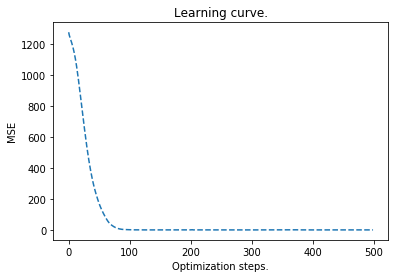

In [9]:
# Create random input/output data
D_in = 500
D_out = 20
N = 64
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Define optimization (learning) steps
max_steps = 500
losses_list = []

# Define learning rate
learning_rate = 1e-6

# Container to store loss through training
closs_list = []

""" COMPLETE CODE BELOW """
# Build network with the following description:
#     layer 1: hidden_units=100, activation=Sigmoid
#     layer 2: hidden_units=200, activation=Tanh
#     layer 3: hidden_units=100, activation=ReLU
net = torch.nn.Sequential(
    torch.nn.Linear(D_in, 100),
    torch.nn.Sigmoid(),
    torch.nn.Linear(100, 200),
    torch.nn.Tanh(),
    torch.nn.Linear(200, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, D_out)
).to(device)

""" COMPLETE CODE BELOW """
# Use Adam optimizer for network optimization
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, eps=1e-08, betas=(0.9, 0.999))


# Define loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

for t in range(max_steps):
    # Forward pass and loss computation
    yhat = net.forward(x)
    loss = loss_fn(yhat, y)
    closs_list.append(loss.item())

    # Compute gradients using backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Take gradient step
    optimizer.step()

# Plot learning curve
plt.title('Learning curve.')
plt.ylabel('MSE')
plt.xlabel('Optimization steps.')
plt.plot(closs_list, '--')

## Regularization

Neural networks are powerful devices. However, if data is small and we are not careful, they will try to fit the training data as perfectly as possible ignoring the true underlying data structure. More importantly, if any noise is present, they will end up overfitting to the noise itself!
Let us create some data below:

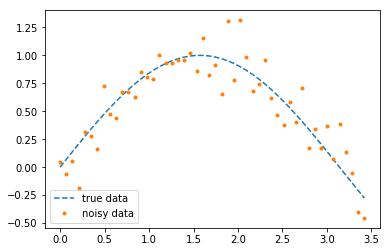

In [10]:
# Let's create some data and plot it
# Train data
xtrain = torch.FloatTensor([i * math.pi / 180 for i in range(0, 200, 4)])
noise = torch.normal(
    torch.zeros(xtrain.shape[0]), torch.ones(xtrain.shape[0]) * 0.2)
ytrue = torch.sin(xtrain)
ynoise_train = torch.sin(xtrain) + noise

# Validation data
xval = torch.FloatTensor([i * math.pi / 180 for i in range(2, 200, 4)])
noise = torch.normal(
    torch.zeros(xval.shape[0]), torch.ones(xval.shape[0]) * 0.2)
ynoise_val = torch.sin(xval) + noise

plt.plot(xtrain.numpy(), ytrue.numpy(), '--', label='true data')
plt.plot(xtrain.numpy(), ynoise_train.numpy(), '.', label='noisy data')
plt.legend(loc='lower left')

There are many ways to regularize neural networks. The first are to purposedly try to reduce the network capacity. In essense, just drop as many weight connections as neccessary. In this tutorial, we will experiment with $\textbf{L1}$ and $\textbf{L2}$ weight regularization:

$$
\begin{equation} 
J(\theta) = \ell(f(x), y; \theta) + \lambda \mathcal{R}(\theta),\nonumber
\end{equation}
$$

where $\ell(f(x), y; \theta)$ is the loss between the network output and the groundtruth data, $\mathcal{R}$ is a regularizer function, and $\lambda$ is a weight we can choose to give the regularization. For L2 regularization $\mathcal{R}(\theta) = \sum^k \|\theta_k\|^2_2$, and for L1 we use $\mathcal{R}(\theta) = \sum^k |\theta_k|$.

Other types of regularization include the highly popular $\textbf{Dropout}$. In essence, dropout turns off random neurons in the network randomly which results in random smaller subset of neurons being able to predict the data. When we apply weight decay, we learn a single "smaller" network that predicts the data. In dropout, we essentially learn an average of multiple smaller networks that predict the data which collaboratively perform better than the single large network with which we started.

Finally, another way to prevent overfitting is $\textbf{early stopping}$. For this technique, we need validation data which we use to test the currently learned network during training. If the validation error starts going down, this indicates overfitting is happening. Once this happens, we stop the training.

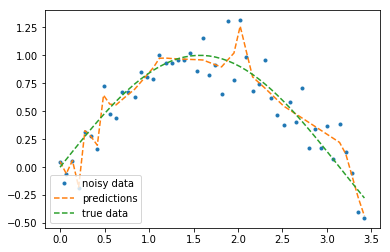

In [11]:
# Number of training steps
max_steps = 10000
hidden_units = 50
lambda_ = 0.0001

# For L1 or L2 regularization
# Uncomment either l1 or l2 to be applied to the network training
reg_type = None
# reg_type = 'l1'
# reg_type = 'l2'

# For dropout regularization
p = 0.0 # percentage of units to drop out [0, 1]

# For early stopping
early_stopping = False
prev_val_loss = None

# Now, let's build a four layer network and train
net = torch.nn.Sequential(
    torch.nn.Linear(1, hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, 1)
).to(device)

# Define optimizer
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)

# Define loss
loss_fn = torch.nn.MSELoss(reduction='mean')

# Train
for t in range(max_steps):
    # Set network to training mode and feedforward through it
    net.train()
    yhat = net.forward(xtrain[:, None])
    
    # Choose type of weight regularizer
    reg_loss = 0.0
    if reg_type is not None:
        if reg_type == 'l1':
            regularizer = lambda x: torch.abs(x)
        elif reg_type == 'l2':
            regularizer = lambda x: x ** 2
        else:
            raise Exception('Unknown regularization: %d' %reg_type)

        for param in net.parameters():
            reg_loss += regularizer(param).sum()
        
    
    # Loss computation
    loss = loss_fn(yhat, ynoise_train[:, None]) + lambda_ * reg_loss
    
    # Compute gradients using backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Take gradient step
    optimizer.step()
    
    # Check early stopping criteria
    if early_stopping and t % 100 == 0:
        net.eval()
        yhat_val = net.forward(xval[:, None])
        curr_val_loss = loss_fn(yhat_val, ynoise_val[:, None])
        if prev_val_loss is not None and prev_val_loss > curr_val_loss:
            print('Early stopping activated!!')
            print('Previous validataion loss %f.' %prev_val_loss)
            print('Current validataion loss %f.' %curr_val_loss)
            break
        prev_val_loss = curr_val_loss

# Eval mode to turn off dropout
net.eval()
yhat = net.forward(xtrain[:, None])
    
plt.plot(xtrain.numpy(), ynoise_train.detach().numpy(), '.', label='noisy data')    
plt.plot(xtrain.numpy(), yhat.detach().numpy(), '--', label='predictions')
plt.plot(xtrain.numpy(), ytrue.detach().numpy(), '--', label='true data')
plt.legend(loc='lower left')


### Exercise: Implement a neural network for binary classification. (15 minutes)

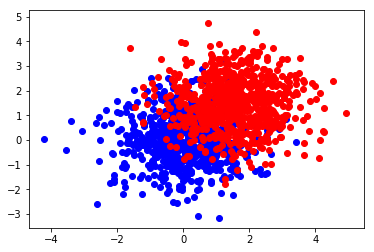

In [12]:
# Generate random data clusters
train_perc = 0.7
val_perc = 0.2
test_perc = 0.1

cluster_offset = 1.5
N = 1000
num_train = int(N * train_perc)
num_val = int(N * val_perc)
num_test = int(N * test_perc)

x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + cluster_offset
xtrain = torch.cat([x1[:num_train], x2[:num_train]], dim=0)
xval = torch.cat([x1[num_train:num_train+num_val], x2[num_train:num_train+num_val]], dim=0)
xtest = torch.cat([x1[-num_test:], x2[-num_test:]], dim=0)

y1 = torch.zeros(N, 1)
y2 = torch.ones(N, 1)
ytrain = torch.cat([y1[:num_train], y2[:num_train]], dim=0)
yval = torch.cat([y1[num_train:num_train+num_val], y2[num_train:num_train+num_val]], dim=0)
ytest = torch.cat([y1[-num_test:], y2[-num_test:]], dim=0)

# Visualize the training data
plt.scatter(x1[:int(N * train_perc), 0], x1[:int(N * train_perc), 1], color='b')
plt.scatter(x2[:int(N * train_perc), 0], x2[:int(N * train_perc), 1], color='r')


# Randomly permute train data
permutation = torch.randperm(xtrain.shape[0])
xtrain = xtrain[permutation]
ytrain = ytrain[permutation]

Train accuracy: 0.872857
Validation accuracy: 0.837500
Test accuracy: 0.840000


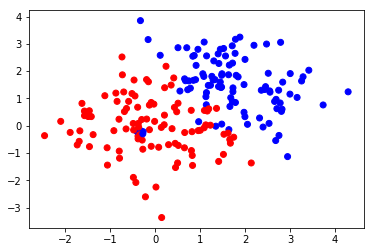

In [13]:
# Number of training steps
max_steps = 10000
hidden_units = 50
lambda_ = 0.0001

# For L1 or L2 regularization
# Uncomment either l1 or l2 to be applied to the network training
reg_type = None
# reg_type = 'l1'
# reg_type = 'l2'

# For dropout regularization
p = 0.0 # percentage of units to drop out [0, 1]

# For early stopping
early_stopping = False
prev_val_loss = None

# Now, let's build a four layer network and train
net = torch.nn.Sequential(
    torch.nn.Linear(xtrain.shape[1], hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=p),
    torch.nn.Linear(hidden_units, 1),
    torch.nn.Sigmoid()
).to(device)

# Define optimizer
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)

# Define loss
loss_fn = torch.nn.BCELoss(reduction='mean')

# Train
for t in range(max_steps):
    # Set network to training mode and feedforward through it
    net.train()
    yhat = net.forward(xtrain)
    
    # Choose type of weight regularizer
    reg_loss = 0.0
    if reg_type is not None:
        if reg_type == 'l1':
            regularizer = lambda x: torch.abs(x)
        elif reg_type == 'l2':
            regularizer = lambda x: x ** 2
        else:
            raise Exception('Unknown regularization: %d' %reg_type)

        for param in net.parameters():
            reg_loss += regularizer(param).sum()
        
    
    # Loss computation
    loss = loss_fn(yhat, ytrain) + lambda_ * reg_loss
    
    # Compute gradients using backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Take gradient step
    optimizer.step()
    
    # Check early stopping criteria
    if early_stopping and t % 100 == 0:
        net.eval()
        yhat_val = net.forward(xval)
        curr_val_loss = loss_fn(yhat_val, yval)
        if prev_val_loss is not None and prev_val_loss > curr_val_loss:
            print('Early stopping activated!!')
            print('Previous validataion loss %f.' %prev_val_loss)
            print('Current validataion loss %f.' %curr_val_loss)
            break
        prev_val_loss = curr_val_loss

# Eval mode to turn off dropout
net.eval()
yhat = net.forward(xtest)
colors = []
for val in yhat:
    if val > 0.5:
        colors.append('b')
    else:
        colors.append('r')
    
# Visualize the testing data and the predicted classes
plt.scatter(xtest[:, 0], xtest[:, 1], color=colors)


yhat = net.forward(xtrain).round()
print('Train accuracy: %f' %(yhat == ytrain).float().mean())


yhat = net.forward(xval).round()
print('Validation accuracy: %f' %(yhat == yval).float().mean())


yhat = net.forward(xtest).round()
print('Test accuracy: %f' %(yhat == ytest).float().mean())

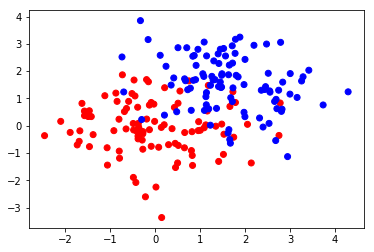

In [14]:
# Let us check what the true test data looks like!
colors = []
for val in ytest:
    if val > 0.5:
        colors.append('b')
    else:
        colors.append('r')
    
# Visualize the training data
plt.scatter(xtest[:, 0], xtest[:, 1], color=colors)

### CONGRATULATIONS! YOU HAVE TRAINED A BINARY CLASSIFICATION NETWORK!